In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
#from mpl_toolkits.basemap import Basemap
#import folium
#from folium import plugins as f_plugins
#import fiona
import shapely
import pandas as pd
import seaborn as sns
import tables
import pickle
import glob
#except:
#    !pip install tables
#    import tables
#from datetime import datetime as dt
#from datetime import timedelta

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.feature import ShapelyFeature
from cartopy.io.img_tiles import MapboxTiles
#from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from string import ascii_lowercase as alphabet

In [2]:
crown_fire_context = pickle.load(open("./datasets/crownfire_contextmap.pickle", "rb" ))

In [2]:
 with open("./mbox_key.txt", "r") as f:
        mbox_key = f.read()

In [3]:
def formatmap(ax,x=True,y=True):
    gl = ax.gridlines(draw_labels=True, alpha=0.2)
    gl.xlabels_bottom = gl.ylabels_left = gl.xlabels_top = gl.ylabels_right = False
    if x:
        gl.xlabels_bottom = True
        gl.xformatter = LONGITUDE_FORMATTER
    if y:
        gl.ylabels_left = True
        gl.yformatter = LATITUDE_FORMATTER
    return ax

def apply_subplot_ticks(ax,x_custom=None,y_custom=None):
    gl = ax.gridlines(draw_labels=True, alpha=0.2)
    gl.xlabels_bottom = gl.ylabels_left = gl.xlabels_top = gl.ylabels_right = False
    if ax in axs[-1]:
        if x_custom is not None:
            lon_formatter = LongitudeFormatter(number_format='.3f',dateline_direction_label=True)
            ax.set_xticks(x_custom, crs=ccrs.PlateCarree())
            ax.xaxis.set_major_formatter(lon_formatter)
        else:
            gl.xlabels_bottom = True
            gl.xformatter = LONGITUDE_FORMATTER

    if ax in axs[:,0]:
        if y_custom is not None:
            lat_formatter = LatitudeFormatter(number_format='.3f',dateline_direction_label=True)
            ax.set_xticks(y_custom, crs=ccrs.PlateCarree())
            ax.xaxis.set_major_formatter(lat_formatter)
        else:
            gl.ylabels_left = True
            gl.yformatter = LATITUDE_FORMATTER
            

def parse_isochrone_source(filename):
    fn_list = os.path.basename(filename).split('.')[0].split('_')
    return ''.join(fn_list[-1])

def parse_isochrone_time(filename,origin_tz=None):
    fn_list = os.path.basename(filename).split('.')[0].split('_')
    strdate, strtime = ''.join(fn_list[1:4]), fn_list[4]
    dt = pd.to_datetime(strdate+strtime, format='%d%m%Y%H%M')
    if origin_tz is not None:
        dt = dt.tz_localize(tz=origin_tz)
        dt = dt.tz_convert('utc')
    else:
        dt = dt.tz_localize(tz='utc')
    return dt

def parse_isochrones(fls):
    isochrone_df = pd.DataFrame({'paths':fls})

    isochrone_df['source'] = isochrone_df['paths'].apply(parse_isochrone_source)

    final_isochrone = isochrone_df[isochrone_df.source == 'final']
    isochrone_df = isochrone_df[isochrone_df.source != 'final'].copy()

    isochrone_df['datetime'] = isochrone_df['paths'].apply(parse_isochrone_time,origin_tz='Australia/Brisbane')
    isochrone_df = isochrone_df.set_index(['datetime'])
    
    start_time = isochrone_df.index.min()
    end_time = isochrone_df.index.max()
    print('Data collection duration: {}'.format(end_time-start_time))
    
    return final_isochrone, isochrone_df

def load_shapefiles_into_gdf(isochrone_df):

    isochrones_gdf = gpd.GeoDataFrame()

    for dt, row in isochrone_df.iterrows():
        iso = gpd.read_file(row['paths'])
        iso['datetime'] = dt
        iso['source'] = row['source']
        if bool(iso.crs):
            isochrones_gdf = isochrones_gdf.append(iso)
        else: 
            print('File is missing crs: {}'.format(row['paths']))
            print('Skipping...')
        
    isochrones_gdf = isochrones_gdf[['geometry','datetime','source']].reset_index()
        
    return isochrones_gdf
def add_isochrones(ax,final_only=False,**final_kwargs):
    handles = []
    labels = []
    
    ax.add_geometries(final_gdf['geometry'],crs=ccrs.PlateCarree(),**final_kwargs)

    if 'facecolor' in final_kwargs.keys():
        handles.append(mpatches.Rectangle((0, 0), 1, 1, **final_kwargs))
    else:
        handles.append(Line2D([0], [0], **final_kwargs))
        
    labels.append('Final perimeter')
        
        
        
    if not final_only:

        color=iter(plt.cm.rainbow_r(np.linspace(0,1,len(isochrones_gdf))))
        for i, row in isochrones_gdf.iloc[::-1].iterrows():
            c=next(color)
            ax.add_geometries([row['geometry']],facecolor=c,crs=ccrs.PlateCarree())
            handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=c))
            labels.append('{} ({})'.format(row['datetime'].tz_convert(target_tz).strftime(time_str_format_map),row['source']))

    return handles, labels

In [4]:
fls = glob.glob('./datasets/Perimeter Shapefiles/*.shp')
fls.sort()
final_isochrone, isochrone_df = parse_isochrones(fls)
final_gdf = gpd.read_file(final_isochrone.iloc[0].paths)
isochrones_gdf = load_shapefiles_into_gdf(isochrone_df)

Data collection duration: 1 days 12:58:00
File is missing crs: ./datasets/Perimeter Shapefiles/Perimeter_5_12_2016_1348_MODIS.shp
Skipping...
File is missing crs: ./datasets/Perimeter Shapefiles/Perimeter_6_12_2016_1338_VIIRS.shp
Skipping...


In [5]:
with open("./mbox_key.txt", "r") as f:
        mbox_key = f.read()
tiler = MapboxTiles(mbox_key,'outdoors')

In [6]:
def get_inset_extent(x0x1y0y1):
    x = [x0x1y0y1[0],x0x1y0y1[0],x0x1y0y1[1],x0x1y0y1[1],x0x1y0y1[0]]
    y = [x0x1y0y1[2],x0x1y0y1[3],x0x1y0y1[3],x0x1y0y1[2],x0x1y0y1[2]]
    return x, y

In [7]:
crownfire_x0x1y0y1 = [151.0427,151.0831,-28.2123,-28.187]
radar_x0x1y0y1 = [151, 151.58, -27.95, -28.3]
regional_x0x1y0y1 = [150.13663, 152.34581, -27.14, -28.75955]
national_x0x1y0y1 = [146.28,158.85,-24,-33]

In [8]:
target_tz = 'Australia/Brisbane'
target_tz_name = 'AEST'
time_str_format_map = '%d/%m/%Y %H:%M'

In [9]:
uq_loc  = (-27.98, 151.19) #344
dalby_loc = (-27.16, 151.26) 
warwick_loc = (-28.21, 152.1) #475m
oakey_loc = (-27.4, 151.74) #405m
wellcamp_loc = (-27.55,151.79) #436m

/Users/Fuego/.local/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


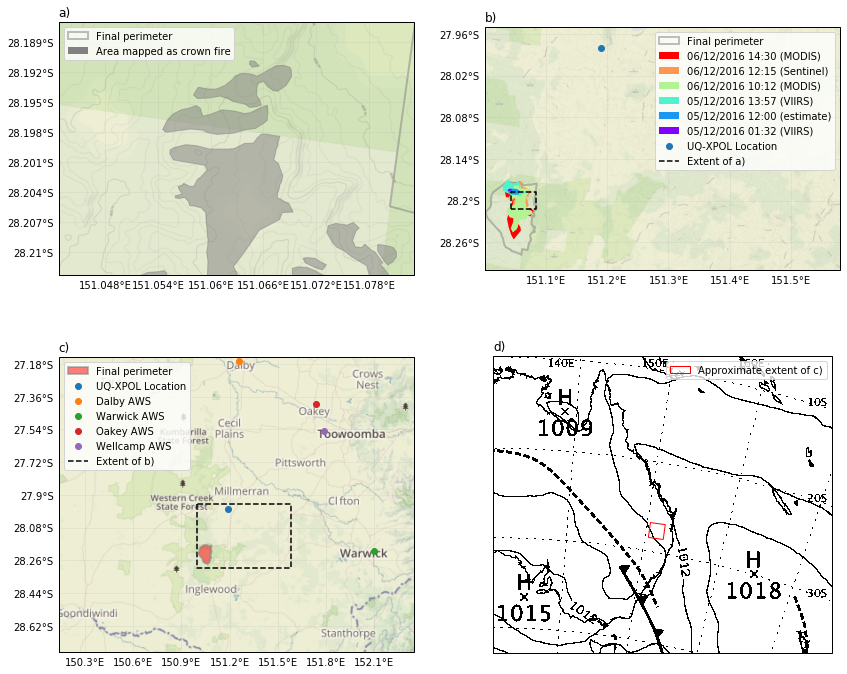

In [111]:
tiles = True

mercator = tiler.crs
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(14,12), subplot_kw={'projection': mercator})

#Panel A
ax1 = axs.reshape(-1)[0]

iso_kwargs={'lw':2,'edgecolor':'grey','facecolor':'none','alpha':0.5}
ax1.set_extent(crownfire_x0x1y0y1, crs=ccrs.PlateCarree())
#handles, labels = add_isochrones(ax1,**iso_kwargs)
handles, labels = add_isochrones(ax1,final_only=True,**iso_kwargs)
ax1.add_geometries(crown_fire_context['data'],edgecolor='grey',facecolor='grey',crs=ccrs.PlateCarree(),alpha=0.5)
#handles.append(Line2D([0], [0],facecolor='grey'))
handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor='grey'))
labels.append('Area mapped as crown fire')
if tiles:
    ax1.add_image(tiler, 15,interpolation='bilinear')

ax1.legend(handles,labels,loc='upper left')

ax1.set_title('a)',loc='left')
ax1 = formatmap(ax1)


# Panel B
ax2 = axs.reshape(-1)[1]
ax2.set_extent(radar_x0x1y0y1, crs=ccrs.PlateCarree())
if tiles:
    ax2.add_image(tiler, 13,interpolation='bilinear')
iso_kwargs={'lw':2,'edgecolor':'grey','facecolor':'none','alpha':0.5}
handles, labels = add_isochrones(ax2,**iso_kwargs)

handles.extend(ax2.plot(uq_loc[1],uq_loc[0],'o',transform=ccrs.PlateCarree()))
labels.append('UQ-XPOL Location')

x,y = get_inset_extent(crown_fire_context['bbox'])
handles.extend(ax2.plot(x, y,'k--',transform=ccrs.PlateCarree()))
labels.append('Extent of a)')

ax2.legend(handles,labels,loc='upper right')
ax2 = formatmap(ax2)
ax2.set_title('b)',loc='left')


#Panel C
ax3 = axs.reshape(-1)[2]
if tiles:
    ax3.add_image(tiler, 8,interpolation='bilinear')
ax3.set_extent(regional_x0x1y0y1, crs=ccrs.PlateCarree())

iso_kwargs={'zorder':5,'lw':2,'edgecolor':'grey','facecolor':'red','alpha':0.5}
handles, labels = add_isochrones(ax3,final_only=True,**iso_kwargs)

handles.extend(ax3.plot(uq_loc[1],uq_loc[0],'o',transform=ccrs.PlateCarree()))
labels.append('UQ-XPOL Location')
handles.extend(ax3.plot(dalby_loc[1],dalby_loc[0],'o',transform=ccrs.PlateCarree()))
labels.append('Dalby AWS')
handles.extend(ax3.plot(warwick_loc[1],warwick_loc[0],'o',transform=ccrs.PlateCarree()))
labels.append('Warwick AWS')
handles.extend(ax3.plot(oakey_loc[1],oakey_loc[0],'o',transform=ccrs.PlateCarree()))
labels.append('Oakey AWS')
handles.extend(ax3.plot(wellcamp_loc[1],wellcamp_loc[0],'o',transform=ccrs.PlateCarree()))
labels.append('Wellcamp AWS')



x,y = get_inset_extent(radar_x0x1y0y1)
handles.extend(ax3.plot(x, y,'k--',transform=ccrs.PlateCarree()))
labels.append('Extent of b)')

ax3.legend(handles,labels,loc='upper left')
ax3 = formatmap(ax3)
ax3.set_title('c)',loc='left')


#Panel D
ax4 = axs.reshape(-1)[3]
#plt.imshow(np.flipud(plt.imread('tas.png')), origin='lower')
# img = np.flipud(plt.imread('./datasets/MSLP_analysis/IDX0102.201612050600.gif'))
# ax4.imshow(img, origin='lower',interpolation='none')

img = plt.imread('./datasets/MSLP_analysis/IDX0102.201612050600.gif')
ax4.imshow(np.flipud(img[3:300,300:-9,:]))
rect = mpatches.Rectangle((155,115),15,15,angle=-8.,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
handle = ax4.add_patch(rect)
ax4.legend([handle],['Approximate extent of c)'],loc='upper right')
# ax4.set_extent(national_x0x1y0y1, crs=ccrs.PlateCarree())
# #ax.add_image(tiler, 1,interpolation='bilinear')
# x,y = get_inset_extent(regional_x0x1y0y1)
# ax4.plot(x, y,'k--',transform=ccrs.PlateCarree())
# ax4 = formatmap(ax4)

ax4.set_title('d)',loc='left')

plt.tight_layout()
plt.savefig('./context_map.png',dpi=300)
plt.show()

In [29]:
national_x0x1y0y1 = [150,155,-26,-30]

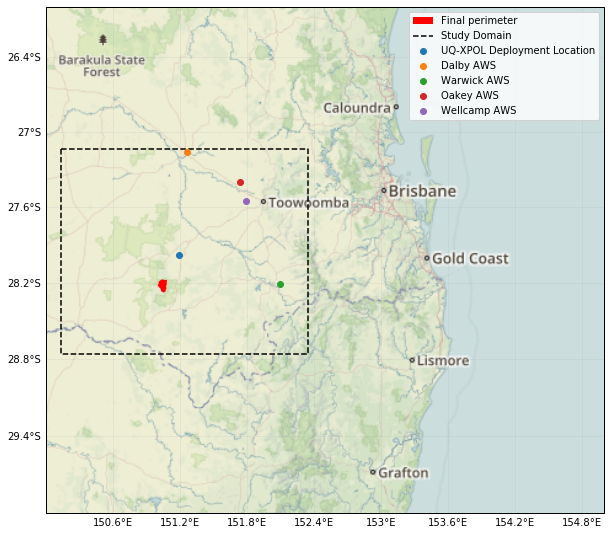

In [31]:
fig = plt.figure(figsize=(10,10))
tiler = MapboxTiles(mbox_key,'outdoors')
mercator = tiler.crs

ax = plt.axes(projection=mercator)
ax.set_extent(national_x0x1y0y1, crs=ccrs.PlateCarree())
ax.add_image(tiler, 7,interpolation='bilinear')
ax = formatmap(ax)

iso_kwargs={'zorder':5,'lw':2,'edgecolor':'none','facecolor':'red'}
handles, labels = add_isochrones(ax,final_only=True,**iso_kwargs)

x,y = get_inset_extent(regional_x0x1y0y1)
handles.extend(ax.plot(x, y,'k--',transform=ccrs.PlateCarree()))
labels.append('Study Domain')

handles.extend(ax.plot(uq_loc[1],uq_loc[0],'o',transform=ccrs.PlateCarree()))
labels.append('UQ-XPOL Deployment Location')
handles.extend(ax.plot(dalby_loc[1],dalby_loc[0],'o',transform=ccrs.PlateCarree()))
labels.append('Dalby AWS')
handles.extend(ax.plot(warwick_loc[1],warwick_loc[0],'o',transform=ccrs.PlateCarree()))
labels.append('Warwick AWS')
handles.extend(ax.plot(oakey_loc[1],oakey_loc[0],'o',transform=ccrs.PlateCarree()))
labels.append('Oakey AWS')
handles.extend(ax.plot(wellcamp_loc[1],wellcamp_loc[0],'o',transform=ccrs.PlateCarree()))
labels.append('Wellcamp AWS')

plt.legend(handles,labels,loc='upper right')
plt.savefig('./overview_map.png',dpi=300)
plt.show()

In [123]:
extents = {'crownfire_x0x1y0y1':crownfire_x0x1y0y1,
          'radar_x0x1y0y1':radar_x0x1y0y1,
          'regional_x0x1y0y1':regional_x0x1y0y1,
          'national_x0x1y0y1':national_x0x1y0y1,
          'uq_loc':uq_loc,
          'dalby_loc':dalby_loc,
          'warwick_loc':warwick_loc,
          'oakey_loc':oakey_loc,
          'wellcamp_loc':wellcamp_loc}
pickle.dump(extents, open( "./datasets/plot_extents.pickle", "wb" ))